# CNN-BiLSTM for Dutch tweets



**References for code**

(1) System architecture code inspired from: https://github.com/saitejdandge/Sentimental_Analysis_LSTM_Conv1D and https://medium.com/appening-io/emotion-classification-2d4ed93bf4e2

(2) Dutch word embeddings trained on social media data: https://github.com/coosto/dutch-word-embeddings/releases

(3) Word embedding layer implemention code inspired from: https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings

(4) Transforming predicted class back to original label inspired from: https://datascience.stackexchange.com/questions/27153/how-to-get-predicted-class-labels-in-convolution-neural-network


**1. Import necessary modules**

In [2]:
import numpy as np
import emoji
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Embedding,Flatten
from keras.layers import LSTM, Bidirectional
from keras.models import load_model, save_model
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
from keras.layers import Embedding,Flatten,Conv1D,MaxPooling1D, Concatenate,Input, GlobalMaxPooling1D, Dropout
from keras.regularizers import l2
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import sys
from keras.callbacks import ModelCheckpoint
import time
import datetime
import os, re, csv, math, codecs
from tqdm import tqdm
import gensim
from sklearn.model_selection import StratifiedKFold
import seaborn as sn

Using TensorFlow backend.


**2. Read & open data**

Change sheet name to 'polarity' or 'emotion' or 'proactivity', depending on the labels you want to train. 

In [7]:
def read_csv(filename, sheetname='sheet'): 
    """
    Reads excel file containing training data and 
    assigns tweets and labels as x or y variable values.
    """
    df = pd.read_excel(open(filename, 'rb'),
               sheet_name=sheetname) 
    x_train_tweets = df.values[:,0]
    y_train_multi = df.values[:,1]
    
    
    return x_train_tweets, y_train_multi

#change sheetname to 'gold-emotion' for emotion training labels
#change sheetname to 'gold-proactivity' for binary proactivity training labels 
x_train, y_train_multi = read_csv('gold.xlsx', 'gold-polarity')  

#change sheetname to 'test-data-emotion' for emotion test labels
#change sheetname to 'test-data-proactivity' for binary proactivity test labels
x_test, y_test_multi = read_csv('gold.xlsx', 'test-data-polarity')
x_test[3]


'   Column: De racistische, politieke terreur van Kuzu en Öztürk '

**3. Count distribution of labels for training**

In [8]:

#count distribution of labels, once again you may change the sheet name. 

df = pd.read_excel(open('gold.xlsx', 'rb'),
               sheet_name='gold-polarity')
df['polarity'].value_counts()

neutral     362
positive    269
negative    268
Name: polarity, dtype: int64

**4. Preprocess data**

In [9]:
def preprocessing2(tweets):
    """
    Program to preprocess data ready for system input. 
    Removes stopwords.
    Returns each tweet as a list of word sequences using the keras 
    preprocessing module 'text_to_word_sequence'
    
    Preprocessing code inspired by: Saitej Dandge Feb 13, 2019. 
    https://github.com/saitejdandge/Sentimental_Analysis_LSTM_Conv1D/blob/master/main.py
    
    """
    dutch_stop_words = set(stopwords.words('dutch')) #from dutch nltk 
    added_stop_words = set(dutch_stop_words)
    
    for stopword in dutch_stop_words: 
        added_stop_words.add(stopword.replace('\'',''))
        pass
    stopWords=added_stop_words
    punct='\n\t!"#$%&()*+,-./:;<=>?[\]^_`{|}~'
    word_seq=[]
    
    for item in tweets:
        item=str(item)
        item=item.replace('\'', '')
        newl = [x for x in text_to_word_sequence(item,filters=punct, lower=True)] #if not x.startswith("@")]
        filtered_sent = [w for w in newl if not w in stopWords] 
        word_seq.append(filtered_sent)
        pass
    return word_seq
x_train_sequences = preprocessing2(x_train)
x_test_sequences = preprocessing2(x_test)

x_test_sequences[3]

['column', 'racistische', 'politieke', 'terreur', 'kuzu', 'öztürk']

**5. Create padded word sequences**

In [10]:
def tokenize_to_index(word_sequences):
    """
    tokenizes tweets that are now word sequences with their index + padding.
    
    Preprocessing code inspired by: Saitej Dandge Feb 13, 2019. 
    https://github.com/saitejdandge/Sentimental_Analysis_LSTM_Conv1D/blob/master/main.py
    
    
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(word_sequences)
    word_indices = tokenizer.texts_to_sequences(word_sequences)
    word_index = tokenizer.word_index
    print("Tokenized to Word indices as ")
    print(np.array(word_indices).shape)

    #padding word_indices

    data=pad_sequences(word_indices,maxlen=20) #?? what does this 'maxlen'=20 do ? 
    print("After padding data")
    print(data.shape)
    
    return word_indices, word_index, data

train_w_indices, train_w_index, train_padded = tokenize_to_index(x_train_sequences)
test_w_indices, test_w_index, test_padded = tokenize_to_index(x_test_sequences)
print()
print('word indices:', train_w_indices[:1])
print()
print('padded:', train_padded[:1])
print()
#print('word + index:', train_w_index)

Tokenized to Word indices as 
(899,)
After padding data
(899, 20)
Tokenized to Word indices as 
(198,)
After padding data
(198, 20)

word indices: [[2029, 316, 2030, 151, 826, 2031, 4, 2032, 265, 1]]

padded: [[   0    0    0    0    0    0    0    0    0    0 2029  316 2030  151
   826 2031    4 2032  265    1]]



**6. Implement word embeddings**

In [11]:

#Word Embeddings from: https://github.com/coosto/dutch-word-embeddings

twitter_embed = gensim.models.KeyedVectors.load_word2vec_format('twitter-dutch-word-embeddings/model.bin', 
                                                                binary=True)

In [12]:
print('Number of dutch twitter embeddings:',len(twitter_embed.vocab))

Number of dutch twitter embeddings: 250479


In [13]:
## loading word embeddings + creating embedding layer inspire from: 
## https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
print('Preparing embedding matrix')
MAX_NB_WORDS = 250479
EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(train_w_index))+1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in train_w_index.items():
    if word in twitter_embed.vocab:
        embedding_matrix[i] = twitter_embed.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


Preparing embedding matrix
Null word embeddings: 1362


In [14]:
embedding_layer = Embedding(len(train_w_index) + 1,
                            300, weights=[embedding_matrix],
                            input_length=20,trainable=False)


**7. Transform label classes into integers**

In [15]:
## encoding labels code inspired from: 
## https://github.com/saitejdandge/Sentimental_Analysis_LSTM_Conv1D/blob/master/main.py

label_encoder = LabelEncoder()
##MULTICLASS
print('THE MULTICLASS LABELS:')
integer_encoded = label_encoder.fit_transform(y_train_multi)
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
print(label_mapping)
y_data_multi=np_utils.to_categorical(integer_encoded)
print(y_data_multi.shape)


THE MULTICLASS LABELS:
{0: 'negative', 1: 'neutral', 2: 'positive'}
(899, 3)


**8. Build CNN-BiLSTM MODEL**

In [16]:
#Building multiclass model. Code initially inspired from Kaggle's CNN-BiLSTM template: 
#https://keras.io/examples/imdb_cnn_lstm/

multimodel=Sequential() #Keras sequential to define each layer in the neural network architecture
multimodel.add(embedding_layer)
multimodel.add(Dropout(0.4))
multimodel.add(Conv1D(filters=64, 
                     kernel_size=5, 
                     padding='valid', 
                     activation= 'relu', 
                     strides=1)) 
multimodel.add(MaxPooling1D(2))
multimodel.add(Dropout(0.5))
multimodel.add(Bidirectional(LSTM(70, return_sequences=True, kernel_regularizer=l2(0.001), 
                                  recurrent_regularizer=l2(0.01), 
                                  bias_regularizer=l2(0.01))))
multimodel.add(Flatten()) 
multimodel.add(Dense(300,activation='relu',  kernel_regularizer=l2(0.01))) 
multimodel.add(Dense(y_data_multi.shape[1],activation="softmax")) 
multimodel.compile(loss="categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

print(multimodel.summary())

#print("Finished Preprocessing data ...")
print("x_data shape : ",train_padded.shape) #the padded tweets
print("y_data shape : ",y_data_multi.shape) #one hot encoded labels
print()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           1703400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 140)            75600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1120)             

**9. Train multiclass model**

In [17]:
x_train_multi, y_train_multi= train_padded, y_data_multi
history = multimodel.fit(x_train_multi, y_train_multi, epochs=38, batch_size=20, validation_split=0.2)

Train on 719 samples, validate on 180 samples
Epoch 1/38
719/719 [==============================] - 2s 3ms/step - loss: 8.7918 - accuracy: 0.3533 - val_loss: 8.7159 - val_accuracy: 0.3944
Epoch 2/38
719/719 [==============================] - 1s 1ms/step - loss: 8.6682 - accuracy: 0.4075 - val_loss: 8.5936 - val_accuracy: 0.4222
Epoch 3/38
719/719 [==============================] - 1s 1ms/step - loss: 8.5398 - accuracy: 0.4367 - val_loss: 8.4687 - val_accuracy: 0.4444
Epoch 4/38
719/719 [==============================] - 1s 1ms/step - loss: 8.4264 - accuracy: 0.4743 - val_loss: 8.3560 - val_accuracy: 0.4722
Epoch 5/38
719/719 [==============================] - 1s 1ms/step - loss: 8.3026 - accuracy: 0.4882 - val_loss: 8.2374 - val_accuracy: 0.5278
Epoch 6/38
719/719 [==============================] - 1s 2ms/step - loss: 8.2022 - accuracy: 0.4896 - val_loss: 8.1136 - val_accuracy: 0.5444
Epoch 7/38
719/719 [==============================] - 1s 1ms/step - loss: 8.0750 - accuracy: 0.5118 - 

**10. Test Multiclass model & make predictions**

In [19]:
test_x = test_padded
predictions = multimodel.predict(test_x) # predict
classes = multimodel.predict_classes(test_x) # predict classes
transformed_classes=label_encoder.inverse_transform(classes) # inverse-transform back to original labels

**11. EVALUATION**

To compare the test/true labels with the predicted labels 


In [20]:

from sklearn.metrics import classification_report
y_true = y_test_multi
y_pred = transformed_classes
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    negative       0.29      0.19      0.23        67
     neutral       0.36      0.43      0.39        69
    positive       0.26      0.29      0.27        62

    accuracy                           0.31       198
   macro avg       0.30      0.31      0.30       198
weighted avg       0.30      0.31      0.30       198



In [22]:
#save output

zipped = list(zip(x_test, y_pred, y_true))
nested_list = [list(item) for item in zipped]
df = pd.DataFrame(nested_list, columns=['tweet','system', 'gold'])
#df.to_excel('NN-emotion-output.xlsx', index=False)



In [24]:
#create confusion matrix. 
#Confusion matrix creation inspired by student Quincy Liem. 

entity_types = ['positive','negative', 'neutral']

def confusion_matrix(gold, system, entity_types):
    confusion_matrix = pd.crosstab(pd.Series(gold),
                                   pd.Series(system),
                                   rownames=['True'],
                                   colnames=['Predicted'],
                                   margins=True)

    df_cm = pd.DataFrame(confusion_matrix,
                         index = entity_types,
                         columns = entity_types)

    sn.set(font_scale=1.2) #for label size
    plt.figure(figsize=(6,4))
    cm = sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},
                    cmap="YlGnBu") #, vmin=0, vmax=1)
    # cm.invert_yaxis()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    # plt.title("Confusion matrix\n")
    plt.show()
    

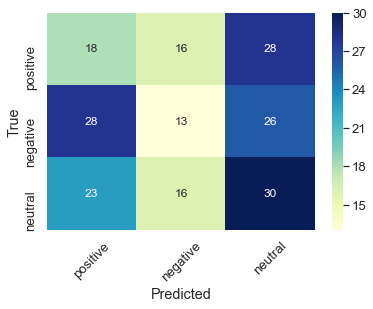

In [25]:
confusion_matrix(df['gold'], df['system'], entity_types)



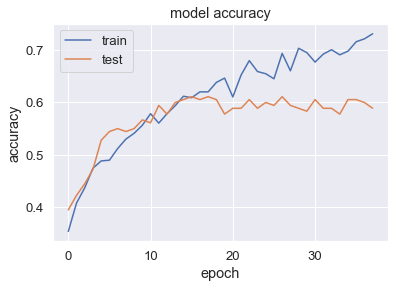

In [27]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**End of Notebook**